In [1]:
import pandas as pd
from HelloAnalytics import get_service, get_first_profile_id

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from string import split

In [3]:
pd.set_option('precision', 2)

In [4]:
#objects for GA connection
scope = ['https://www.googleapis.com/auth/analytics.readonly']
service = get_service('analytics', 'v3', scope, 'client_secret_ga.json')
#profile = get_first_profile_id(service)

In [161]:
def return_df_ga(start_date,end_date,start_index,max_results):
    df = service.data().ga().get(
      ids='ga:58090804',
      start_date=start_date,
      end_date=end_date,
      metrics='ga:searchUniques,ga:avgSearchDepth,ga:avgSearchDuration,ga:searchExitRate,ga:searchGoal1ConversionRate',
      dimensions = 'ga:searchKeyword',
      output = 'dataTable',
      samplingLevel = 'HIGHER_PRECISION',
      start_index = start_index,
      max_results = max_results,
      fields = 'columnHeaders/name,dataTable',
      sort = '-ga:searchUniques'
      #fields = 'columnHeaders/name,dataTable/rows'
      ).execute()
    print start_index
    return data_frame_from_ga(df)

In [151]:
df = service.data().ga().get(
      ids='ga:58090804',
      start_date='2015-10-12',
      end_date='2015-11-11',
      metrics='ga:searchUniques,ga:avgSearchDepth,ga:avgSearchDuration,ga:searchExitRate,ga:searchGoal1ConversionRate',
      dimensions = 'ga:searchKeyword',
      output = 'dataTable',
      samplingLevel = 'HIGHER_PRECISION',
      start_index = 1000,
      max_results = 1000,
      fields = 'columnHeaders/name,dataTable',
      sort = '-ga:searchUniques'
      #fields = 'columnHeaders/name,dataTable/rows'
      ).execute()

In [ ]:
%time df5 = pd.concat([return_df_ga('2015-10-12','2015-11-11',i,10000) for i in range(1,1000000,10000)])
%time df6 = pd.concat([return_df_ga('2015-11-12','2015-12-10',i,10000) for i in range(1,1000000,10000)])

1
10001
20001

In [221]:
def data_frame_from_ga(df):
    try:
        df2 = pd.concat([pd.DataFrame(row['c']) for row in df['dataTable']['rows']],axis = 1).transpose()
        df2.columns = [row['name'].replace('ga:','') for row in df['columnHeaders']]
        df2.index = range(len(df2))
        for col in list(df2.columns):
            try:
                df2[col] = df2[col].apply(lambda x: float(x))
            except:
                pass
    except KeyError:
        df2 = pd.DataFrame([{row['name'].replace('ga:',''):0} for row in df['columnHeaders']]).dropna()
        pass
    return df2

In [357]:
df6.to_pickle('afterAlice.pkl')
df5.to_pickle('beforeAlice.pkl')

In [ ]:
writer = pd.ExcelWriter('data.xlsx')
df6.to_excel(writer,'Sheet1')
df5.to_excel(writer,'Sheet2')
writer.save()

In [339]:
df2 = df6 #After Alice
df3 = df5 #before Alice

In [370]:
df3['term_length'] = df3.searchKeyword.apply(lambda x: len(split(x,sep = ' ')))

flag1 = df3.avgSearchDepth < df3.avgSearchDepth.quantile(0.95)
flag2 = df3.avgSearchDuration < df3.avgSearchDuration.quantile(0.95)
flag3 = df3.searchExitRate < 101 #df3.searchExitRate.quantile(0.95)
flag4 = ((df3.searchGoal1ConversionRate < 50) & (df3.searchGoal1ConversionRate > 0))#df3.searchGoal1ConversionRate.quantile(1)
df3 = df3.ix[(flag1 & flag2 & flag3),:]

index2 = pd.MultiIndex.from_arrays([np.array(df3.index),np.array(df3.term_length)],names = [u'basic',u'term'])

df3.index = index2
df3_mean = df3.ix[:,range(1,6)].mean(level = 'term').iloc[range(5)]
df3_mean['term'] = list(df3_mean.index)
df3_std = df3.ix[:,range(1,6)].std(level = 'term').iloc[range(5)]
df3_std['term'] = list(df3_std.index)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [371]:
df3_mean

,avgSearchDuration,searchExitRate,searchGoal1ConversionRate,searchUniques,term
term,,,,,
1,86.43,18.08,0.06,5.69,1
2,82.22,20.22,0.05,2.70,2
3,81.96,20.77,0.04,1.89,3
4,76.19,20.38,0.02,1.36,4
5,71.57,19.38,0.03,1.16,5


In [374]:
df2

,,avgSearchDepth,avgSearchDuration,searchExitRate,searchGoal1ConversionRate,searchKeyword,searchUniques,term_length
basic,term,,,,,,,
0,1,1.65,149.25,15.56,0.86,(other),530041,1
1,1,3.79,329.81,27.14,0.70,iphone,12999,1
2,2,1.90,240.76,38.08,0.48,iphone 6,9565,2
3,2,4.51,357.34,26.07,0.63,samsung s6,9543,2
4,1,0.63,68.03,81.78,0.21,cinturilla,9318,1
5,2,3.89,342.45,25.27,1.49,iphone 6s,7744,2
6,2,2.72,279.87,28.86,0.37,note 5,6722,2
7,2,4.43,348.60,29.77,1.17,s6 edge,6650,2
8,1,1.43,132.62,42.82,0.39,ipad,5108,1


In [372]:
df2.ix[range(10),:].describe()

,avgSearchDepth,avgSearchDuration,searchExitRate,searchGoal1ConversionRate,searchUniques,term_length
count,10.00,10.00,10.00,10.00,10.00,10.00
mean,3.08,276.64,34.12,0.74,60257.40,1.50
std,1.66,132.80,18.30,0.41,165083.01,0.53
min,0.63,68.03,15.56,0.21,4884.00,1.00
25%,1.71,172.13,25.94,0.41,6668.00,1.00
50%,3.26,304.84,28.00,0.66,8531.00,1.50
75%,4.30,347.06,36.00,1.04,9559.50,2.00
max,5.84,517.64,81.78,1.49,530041.00,2.00


In [260]:
def add_position(df,n_terms):
    df2 = df
    df2['#terms'] = n_terms
    return df2 

In [318]:
searchGoal1ConversionRate2

mean    0.09
mean    1.31
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
mean    1.33
Name: searchGoal1ConversionRate, dtype: float64

In [347]:
df_describe2 = pd.concat([add_position(df2.ix[range(i+1),:].describe(),i) for i in range (0,610000,10000)])
df_describe3 = pd.concat([add_position(df3.ix[range(i+1),:].describe(),i) for i in range (0,610000,10000)])

avgSearchDepth2 = df_describe2.loc['mean','avgSearchDepth']
avgSearchDuration2 = df_describe2.loc['mean','avgSearchDuration']
searchExitRate2 = df_describe2.loc['mean','searchExitRate']
searchGoal1ConversionRate2 = df_describe2.loc['mean','searchGoal1ConversionRate']
top_terms2 = df_describe2.loc['count','#terms']

avgSearchDepth3 = df_describe3.loc['mean','avgSearchDepth']
avgSearchDuration3 = df_describe3.loc['mean','avgSearchDuration']
searchExitRate3 = df_describe3.loc['mean','searchExitRate']
searchGoal1ConversionRate3 = df_describe3.loc['mean','searchGoal1ConversionRate']
top_terms3 = df_describe3.loc['count','#terms']

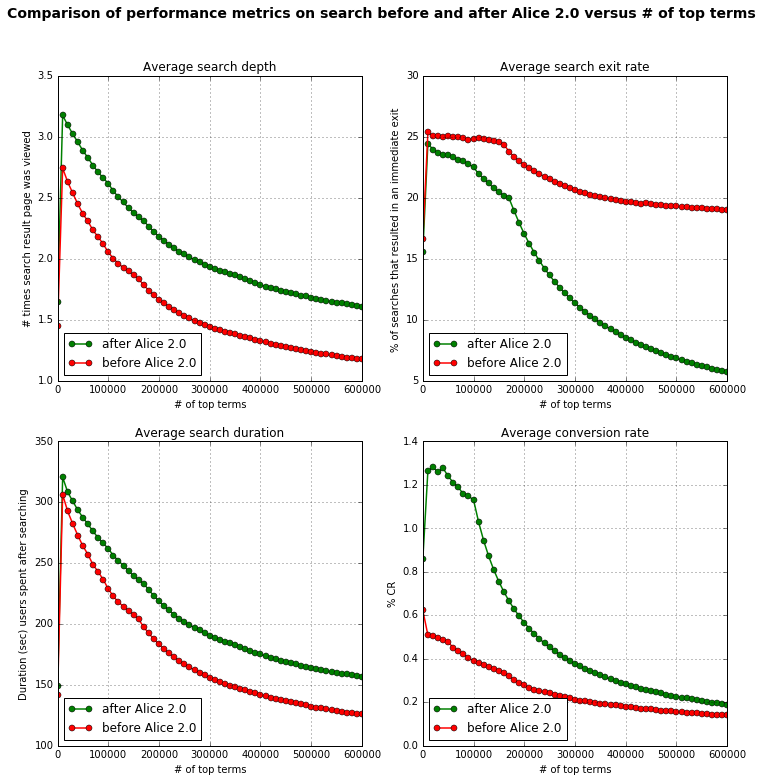

In [348]:
#setting size of the plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

fig, ((ax1, ax2,), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(top_terms2,avgSearchDepth2, 'go-',linewidth = 1.5, label = 'after Alice 2.0')
ax1.plot(top_terms3,avgSearchDepth3, 'ro-',linewidth = 1.5, label = 'before Alice 2.0')

ax1.set_title('Average search depth')
ax1.set_ylabel('# times search result page was viewed')
ax1.set_xlabel('# of top terms')
ax1.legend(loc='lower left')
ax1.grid(True)


ax2.plot(top_terms2,searchExitRate2, 'go-',linewidth = 1.5, label = 'after Alice 2.0')
ax2.plot(top_terms3,searchExitRate3, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')

ax2.set_title('Average search exit rate')
ax2.set_ylabel('% of searches that resulted in an immediate exit ')
ax2.set_xlabel('# of top terms')
ax2.legend(loc='lower left')
ax2.grid(True)


ax3.plot(top_terms2,avgSearchDuration2, 'go-',linewidth = 1.5,label = 'after Alice 2.0')
ax3.plot(top_terms3,avgSearchDuration3, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')

ax3.set_title('Average search duration')
ax3.set_ylabel('Duration (sec) users spent after searching')
ax3.set_xlabel('# of top terms')
ax3.legend(loc='lower left')
ax3.grid(True)


ax4.plot(top_terms2,searchGoal1ConversionRate2, 'go-',linewidth = 1.5, label = 'after Alice 2.0')
ax4.plot(top_terms2,searchGoal1ConversionRate3, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')

ax4.set_title('Average conversion rate')
ax4.set_ylabel('% CR')
ax4.set_xlabel('# of top terms')
ax4.legend(loc='lower left')
ax4.grid(True)

fig.suptitle('Comparison of performance metrics on search before and after Alice 2.0 versus # of top terms', fontsize=14, fontweight='bold') ;

In [342]:
df2['term_length'] = df2.searchKeyword.apply(lambda x: len(split(x,sep = ' ')))

flag1 = df2.avgSearchDepth < df2.avgSearchDepth.quantile(0.95)
flag2 = df2.avgSearchDuration < df2.avgSearchDuration.quantile(0.95)
flag3 = df2.searchExitRate < df2.searchExitRate.quantile(0.95)
flag4 = df2.searchGoal1ConversionRate < df2.searchGoal1ConversionRate.quantile(0.99)
df2 = df2.ix[(flag1 & flag2 & flag3 & flag4),:]

index2 = pd.MultiIndex.from_arrays([np.array(df2.index),np.array(df2.term_length)],names = [u'basic',u'term'])

df2.index = index2
df2_mean = df2.ix[:,range(1,6)].mean(level = 'term').iloc[range(5)]
df2_mean['term'] = list(df2_mean.index)
df2_std = df2.ix[:,range(1,6)].std(level = 'term').iloc[range(5)]
df2_std['term'] = list(df2_std.index)

In [354]:
df2

,avgSearchDuration,searchExitRate,searchGoal1ConversionRate,searchUniques,term
term,,,,,
1,171.83,8.11,0.27,16.02,1
2,160.27,6.60,0.23,4.36,2
3,157.77,5.29,0.17,2.74,3
4,145.93,3.58,0.10,1.80,4
5,134.58,2.49,0.05,1.42,5


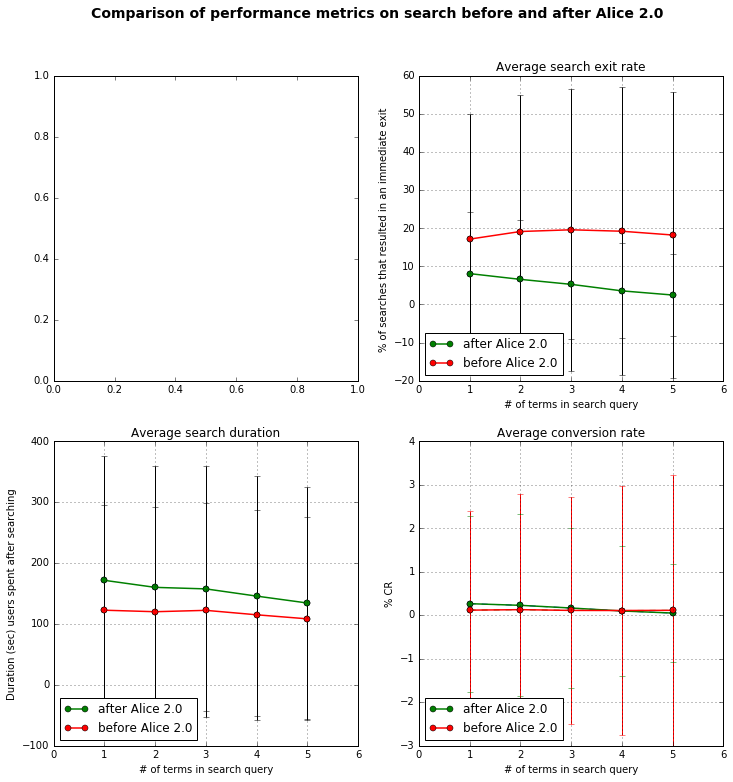

In [355]:
#setting size of the plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

fig, ((ax1, ax2,), (ax3, ax4)) = plt.subplots(2, 2)

ax1.errorbar(df2_mean.term,list(df2_mean.avgSearchDepth) ,yerr=list(df2_std.avgSearchDepth), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax1.plot(df2_mean.term,df2_mean.avgSearchDepth, 'go-',linewidth = 1.5, label = 'after Alice 2.0')

ax1.errorbar(df3_mean.term,list(df3_mean.avgSearchDepth), yerr=list(df3_std.avgSearchDepth), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax1.plot(df3_mean.term,df3_mean.avgSearchDepth, 'ro-',linewidth = 1.5, label = 'before Alice 2.0')

ax1.set_title('Average search depth')
ax1.set_ylabel('# times search result page was viewed')
ax1.set_xlabel('# of terms in search query')
ax1.set_xlim(0,6)
ax1.legend(loc='lower left')
ax1.grid(True)

ax2.errorbar(df2_mean.term,list(df2_mean.searchExitRate), yerr=list(df2_std.searchExitRate), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax2.plot(df2_mean.term,df2_mean.searchExitRate, 'go-',linewidth = 1.5, label = 'after Alice 2.0')

ax2.errorbar(df3_mean.term,list(df3_mean.searchExitRate), yerr=list(df3_std.searchExitRate), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax2.plot(df3_mean.term,df3_mean.searchExitRate, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')
ax2.set_title('Average search exit rate')
ax2.set_ylabel('% of searches that resulted in an immediate exit ')
ax2.set_xlabel('# of terms in search query')
ax2.legend(loc='lower left')
ax2.set_xlim(0,6)
ax2.grid(True)

ax3.errorbar(df2_mean.term,list(df2_mean.avgSearchDuration), yerr=list(df2_std.avgSearchDuration), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax3.plot(df2_mean.term,df2_mean.avgSearchDuration, 'go-',linewidth = 1.5,label = 'after Alice 2.0')

ax3.errorbar(df3_mean.term,list(df3_mean.avgSearchDuration), yerr=list(df3_std.avgSearchDuration), 
             fmt='o',ecolor='k',linewidth = 1, label = '')
ax3.plot(df3_mean.term,df3_mean.avgSearchDuration, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')

ax3.set_title('Average search duration')
ax3.set_ylabel('Duration (sec) users spent after searching')
ax3.set_xlabel('# of terms in search query')
ax3.legend(loc='lower left')
ax3.set_xlim(0,6)
ax3.grid(True)

ax4.errorbar(df2_mean.term,list(df2_mean.searchGoal1ConversionRate), yerr=list(df2_std.searchGoal1ConversionRate), 
             fmt='o',ecolor='g',linestyle = 'dashed',linewidth = 1, label = '')
ax4.plot(df2_mean.term,df2_mean.searchGoal1ConversionRate, 'go-',linewidth = 1.5, label = 'after Alice 2.0')

ax4.errorbar(df3_mean.term,list(df3_mean.searchGoal1ConversionRate), yerr=list(df3_std.searchGoal1ConversionRate), 
             fmt='o',ecolor='r',linestyle = 'dashed',linewidth = 1, label = '')
ax4.plot(df3_mean.term,df3_mean.searchGoal1ConversionRate, 'ro-',linewidth = 1.5,label = 'before Alice 2.0')
ax4.set_title('Average conversion rate')
ax4.set_ylabel('% CR')
ax4.set_xlabel('# of terms in search query')
ax4.legend(loc='lower left')
ax4.set_xlim(0,6)
ax4.grid(True)

fig.suptitle('Comparison of performance metrics on search before and after Alice 2.0', fontsize=14, fontweight='bold') ;

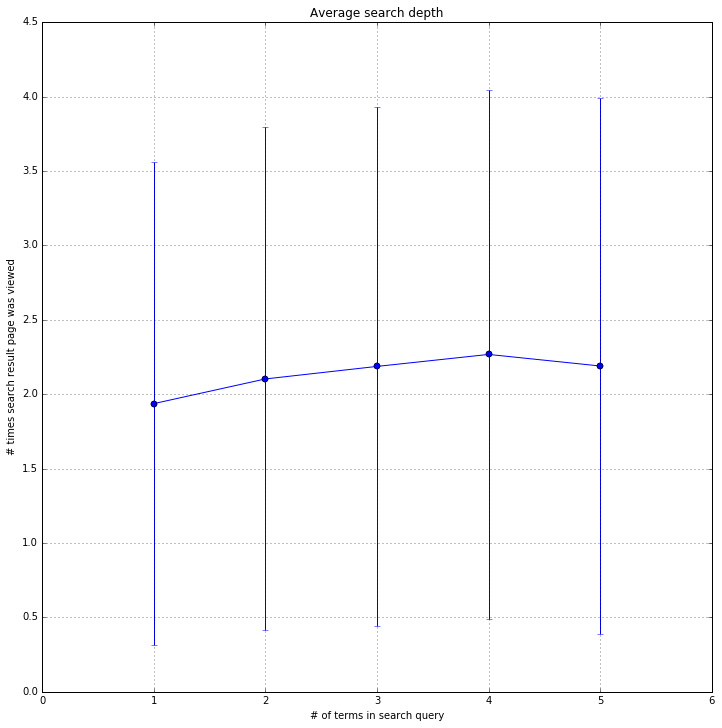

In [228]:
fig, ax = plt.subplots()

ax.plot(df2_mean.term,df2_mean.avgSearchDepth, 'bo-')
ax.set_title('Average search depth')
ax.set_ylabel('# times search result page was viewed')
ax.set_xlabel('# of terms in search query')
ax.errorbar(df2_mean.term,df2_mean.avgSearchDepth, yerr=list(df2_std.avgSearchDepth), fmt='o')
ax.set_xlim(0,6)
ax.grid(True)

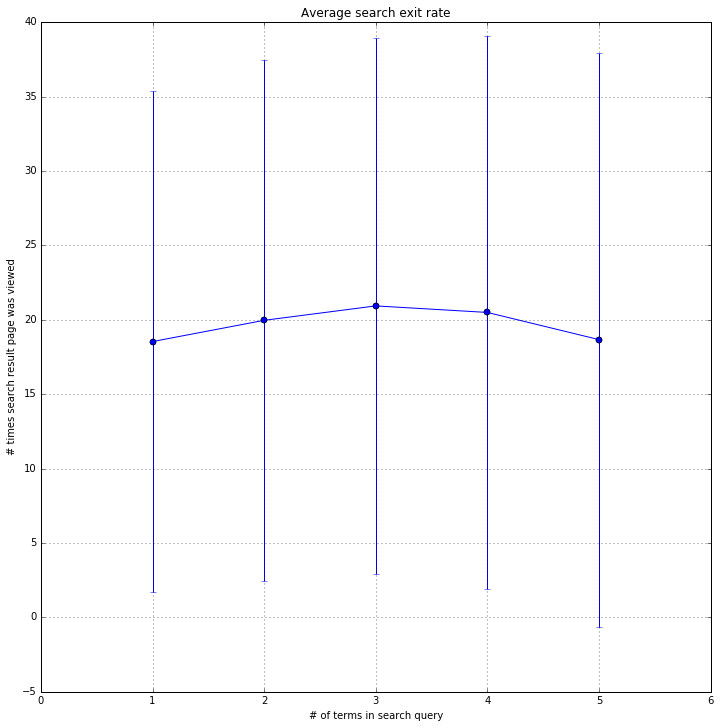

In [229]:
fig, ax = plt.subplots()

ax.plot(df2_mean.term,df2_mean.searchExitRate, 'bo-')
ax.set_title('Average search exit rate')
ax.set_ylabel('# times search result page was viewed')
ax.set_xlabel('# of terms in search query')
ax.errorbar(df2_mean.term,df2_mean.searchExitRate, yerr=list(df2_std.searchExitRate), fmt='o')
ax.set_xlim(0,6)
ax.grid(True)

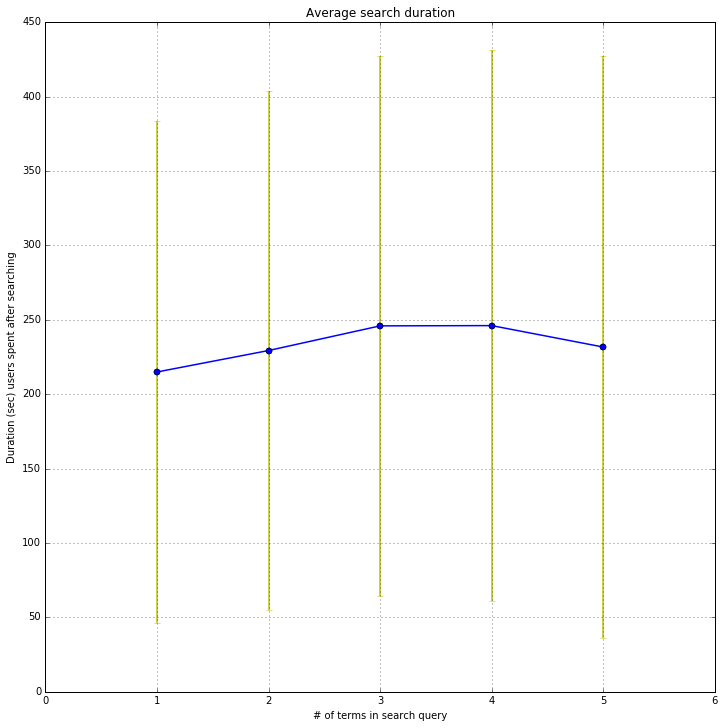

In [230]:
fig, ax = plt.subplots()

ax.plot(df2_mean.term,df2_mean.avgSearchDuration, 'bo-',linewidth = 1.5)
ax.set_title('Average search duration')
ax.set_ylabel('Duration (sec) users spent after searching')
ax.set_xlabel('# of terms in search query')
ax.errorbar(df2_mean.term,df2_mean.avgSearchDuration, yerr=list(df2_std.avgSearchDuration), fmt='o',ecolor='y',linewidth = 1.5)
ax.set_xlim(0,6)
ax.grid(True)

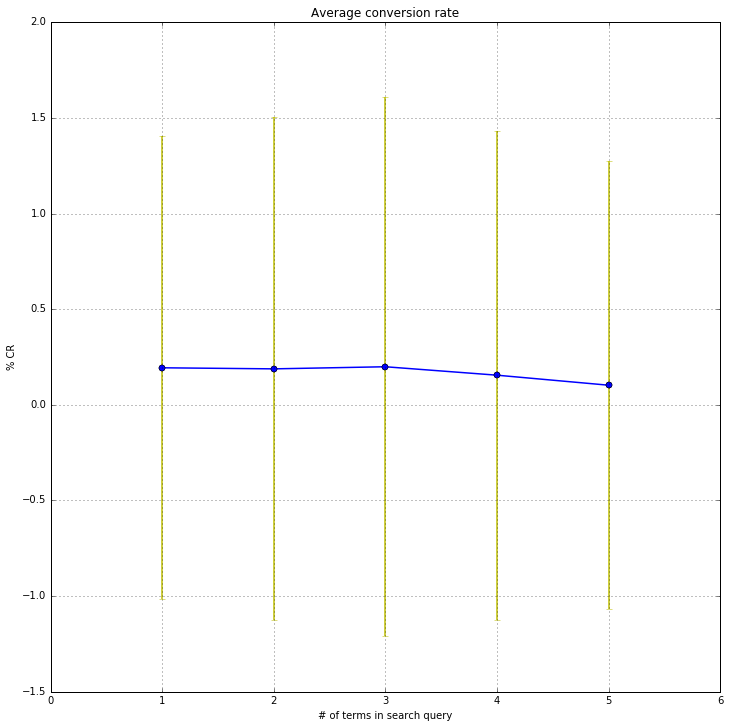

In [231]:
fig, ax = plt.subplots()

ax.plot(df2_mean.term,df2_mean.searchGoal1ConversionRate, 'bo-',linewidth = 1.5)
ax.set_title('Average conversion rate')
ax.set_ylabel('% CR')
ax.set_xlabel('# of terms in search query')
ax.errorbar(df2_mean.term,df2_mean.searchGoal1ConversionRate, yerr=list(df2_std.searchGoal1ConversionRate), fmt='o',ecolor='y',linewidth = 1.5)
ax.set_xlim(0,6)
ax.grid(True)

In [232]:
testdf = pd.DataFrame([{u'v': u'!hey dog'},
   {u'v': u'1'},
   {u'v': u'0.0'},
   {u'v': u'14.0'},
   {u'v': u'0.0'},
   {u'v': u'0.0'}]).transpose()

In [233]:
testdf

,0,1,2,3,4,5
v,!hey dog,1,0.0,14.0,0.0,0.0


In [234]:
[row['name'] for row in df['columnHeaders']]

[u'ga:searchKeyword',
 u'ga:searchUniques',
 u'ga:avgSearchDepth',
 u'ga:avgSearchDuration',
 u'ga:searchExitRate',
 u'ga:searchGoal1ConversionRate']

In [235]:
for row in df['dataTable']['rows']

SyntaxError: invalid syntax (<ipython-input-235-80e864ed94d6>, line 1)

In [ ]:
pd.concat([pd.DataFrame(row['c']) for row in df['dataTable']['rows']],axis = 1).transpose()

In [ ]:
t1 = df2.ix[df2.term_length == 1,range(1,5)].apply(np.mean)
sd1 = df2.ix[df2.term_length == 1,range(1,5)].apply(np.std)

t2 = df2.ix[df2.term_length == 2,range(1,5)].apply(np.mean)
sd2 = df2.ix[df2.term_length == 2,range(1,5)].apply(np.std)

t3 = df2.ix[df2.term_length == 3,range(1,5)].apply(np.mean)
sd3 = df2.ix[df2.term_length == 3,range(1,5)].apply(np.std)

t4 = df2.ix[df2.term_length == 4,range(1,5)].apply(np.mean)
sd4 = df2.ix[df2.term_length == 4,range(1,5)].apply(np.std)